In [1]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("cc_data").getOrCreate()

In [5]:
spark

In [8]:
df = spark.read.csv("CC GENERAL.csv",header=True, inferSchema=True)

In [9]:
df.show()

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

In [10]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [22]:
df = df.na.drop()

In [23]:
from pyspark.ml.feature import VectorAssembler

In [24]:
df.columns 

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [25]:
## cols to be used for training
cols_ = [i for i in df.columns if i!="CUST_ID"]
cols_

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [26]:
featureassembler = VectorAssembler(inputCols=cols_,outputCol="independent features")

In [27]:
output = featureassembler.transform(df)
output.show()

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|independent features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

In [28]:
from pyspark.ml.feature import StandardScaler



In [34]:
scale = StandardScaler(inputCol="independent features",outputCol="standardized")
df_scale = scale.fit(output)
df_scale_out = df_scale.transform(output)
df_scale_out.show()

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|independent features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

In [32]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [80]:
df_scale_out.columns

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE',
 'independent features',
 'standardized']

In [45]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol = 'standardized',
                               metricName="silhouette", distanceMeasure ="squaredEuclidean")

silhouette_score  = []
for i in range(2,10):
    kmeans = KMeans(featuresCol="standardized", k=i)
    kmeans_fit = kmeans.fit(df_scale_out)
    output = kmeans_fit.transform(df_scale_out)
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhoute Score: ", score )

Silhoute Score:  0.2902206470897065
Silhoute Score:  0.2730998192853565
Silhoute Score:  0.28239325551728617
Silhoute Score:  0.27938553636939534
Silhoute Score:  0.28197086371378494
Silhoute Score:  0.27414928778364017
Silhoute Score:  0.3075488326552787
Silhoute Score:  0.2922934701939621


In [46]:
# !pip install matplotlib
import matplotlib.pyplot as plt

Text(0, 0.5, 'cost')

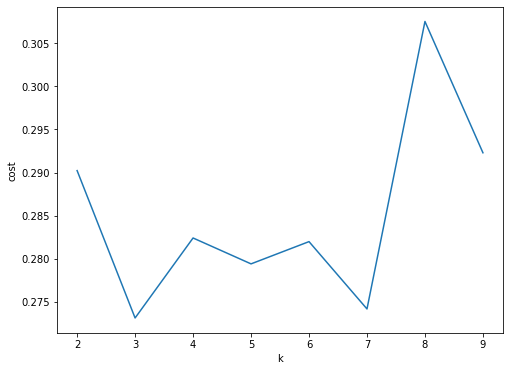

In [47]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

#### live stream data

In [49]:
dataset = spark.read.csv("LiveTV_Stream.csv",header=True,inferSchema=True)
dataset.show()

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|Column1|Column2|Column3|Column4|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|   null|   null|   null|   null|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|   null|   null|   null|   null|
|246675545449582_1...|      video|  4/21/2018 6:17|          227|         236|        57|      

In [50]:
dataset.printSchema()

root
 |-- status_id: string (nullable = true)
 |-- status_type: string (nullable = true)
 |-- status_published: string (nullable = true)
 |-- num_reactions: integer (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- num_shares: integer (nullable = true)
 |-- num_likes: integer (nullable = true)
 |-- num_loves: integer (nullable = true)
 |-- num_wows: integer (nullable = true)
 |-- num_hahas: integer (nullable = true)
 |-- num_sads: integer (nullable = true)
 |-- num_angrys: integer (nullable = true)
 |-- Column1: string (nullable = true)
 |-- Column2: string (nullable = true)
 |-- Column3: string (nullable = true)
 |-- Column4: string (nullable = true)



In [54]:
dataset.show()

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|Column1|Column2|Column3|Column4|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|   null|   null|   null|   null|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|   null|   null|   null|   null|
|246675545449582_1...|      video|  4/21/2018 6:17|          227|         236|        57|      

In [60]:
dataset.columns

['status_id',
 'status_type',
 'status_published',
 'num_reactions',
 'num_comments',
 'num_shares',
 'num_likes',
 'num_loves',
 'num_wows',
 'num_hahas',
 'num_sads',
 'num_angrys',
 'Column1',
 'Column2',
 'Column3',
 'Column4']

In [62]:
dataset = dataset.select(['status_id',
 'status_type',
 'status_published',
 'num_reactions',
 'num_comments',
 'num_shares',
 'num_likes',
 'num_loves',
 'num_wows',
 'num_hahas',
 'num_sads',
 'num_angrys'])


In [70]:
dataset.printSchema()

root
 |-- status_id: string (nullable = true)
 |-- status_type: string (nullable = true)
 |-- status_published: string (nullable = true)
 |-- num_reactions: integer (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- num_shares: integer (nullable = true)
 |-- num_likes: integer (nullable = true)
 |-- num_loves: integer (nullable = true)
 |-- num_wows: integer (nullable = true)
 |-- num_hahas: integer (nullable = true)
 |-- num_sads: integer (nullable = true)
 |-- num_angrys: integer (nullable = true)



In [69]:
h = dataset.na.drop()
h.count()

7050

In [73]:
from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(inputCols=['num_reactions',
 'num_comments',
 'num_shares',
 'num_likes',
 'num_loves',
 'num_wows',
 'num_hahas',
 'num_sads',
 'num_angrys'],outputCol='independent features')
assembled_data = assemble.transform(h)
assembled_data.show()

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------------------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|independent features|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------------------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|[529.0,512.0,262....|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|(9,[0,3],[150.0,1...|
|246675545449582_1...|      video|  4/21/2018 6:17|          227|         236|        57|      204|       21|       1|        1|       0|         0|[2

In [74]:
scale = StandardScaler(inputCol='independent features', outputCol="standardized")
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.show()

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------------------+--------------------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|independent features|        standardized|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------------------+--------------------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|[529.0,512.0,262....|[1.14347397246561...|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|(9,[0,3],[150.0,1...|(9,[0,3],[0.32423...|
|246675545449582_1...|      video|  4/21/2018

In [75]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol='standardized', metricName='silhouette',distanceMeasure="squaredEuclidean")

for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.9088294365792938
Silhouette Score: 0.8459717007099314
Silhouette Score: 0.846742163785216
Silhouette Score: 0.7893593487914574
Silhouette Score: 0.7983369724450986
Silhouette Score: 0.7997758442741595
Silhouette Score: 0.8028143500519963
Silhouette Score: 0.8020970449920696


Text(0, 0.5, 'cost')

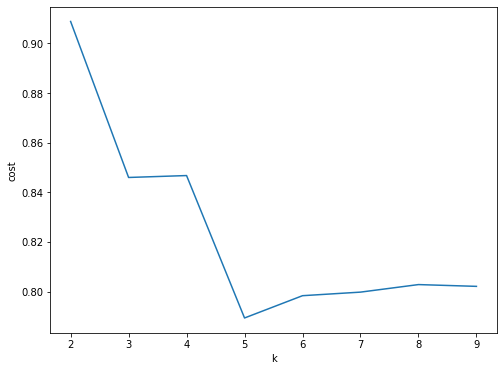

In [77]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [78]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
    
KMeans_fit=KMeans_algo.fit(data_scale_output)

output=KMeans_fit.transform(data_scale_output)
output.show()

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------------------+--------------------+----------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|independent features|        standardized|prediction|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+--------------------+--------------------+----------+
|246675545449582_1...|      video|  4/22/2018 6:00|          529|         512|       262|      432|       92|       3|        1|       1|         0|[529.0,512.0,262....|[1.14347397246561...|         0|
|246675545449582_1...|      photo| 4/21/2018 22:45|          150|           0|         0|      150|        0|       0|        0|       0|         0|(9,[0,3],[150.0,1...|(9,[0,3],[0.32423...|  